In [1]:
import matplotlib.pyplot as plt
import torch
import pandas as pd
import cv2
import random
import numpy as np
from torch.utils.data import Dataset
import tensorflow as tf

2024-04-06 06:41:32.767773: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 06:41:32.767934: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 06:41:33.047791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 2


In [5]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Create a csv file containing the image and mask paths

In [6]:
import os
images  = os.listdir('/kaggle/input/cvc-colondb/CVC-ColonDB/images')
images.sort()
images[:10]

['1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png']

In [7]:
masks = os.listdir('/kaggle/input/cvc-colondb/CVC-ColonDB/masks')
masks.sort()
masks[:10]

['1.png',
 '10.png',
 '100.png',
 '101.png',
 '102.png',
 '103.png',
 '104.png',
 '105.png',
 '106.png',
 '107.png']

In [8]:
col = {'images':images,'masks': masks}
df = pd.DataFrame(col)
df.to_csv('/kaggle/working/metadata1.csv')

In [9]:
df.head()

,images,masks
0,1.png,1.png
1,10.png,10.png
2,100.png,100.png
3,101.png,101.png
4,102.png,102.png


In [10]:
df['images'] = '/kaggle/input/cvc-colondb/CVC-ColonDB/images/' + df['images']
df['masks'] = '/kaggle/input/cvc-colondb/CVC-ColonDB/masks/' + df['masks']

In [11]:
df.head()

,images,masks
0,/kaggle/input/cvc-colondb/CVC-ColonDB/images/1...,/kaggle/input/cvc-colondb/CVC-ColonDB/masks/1.png
1,/kaggle/input/cvc-colondb/CVC-ColonDB/images/1...,/kaggle/input/cvc-colondb/CVC-ColonDB/masks/10...
2,/kaggle/input/cvc-colondb/CVC-ColonDB/images/1...,/kaggle/input/cvc-colondb/CVC-ColonDB/masks/10...
3,/kaggle/input/cvc-colondb/CVC-ColonDB/images/1...,/kaggle/input/cvc-colondb/CVC-ColonDB/masks/10...
4,/kaggle/input/cvc-colondb/CVC-ColonDB/images/1...,/kaggle/input/cvc-colondb/CVC-ColonDB/masks/10...


In [12]:
df.shape

(380, 2)

In [13]:
df.iloc[4][1]

'/kaggle/input/cvc-colondb/CVC-ColonDB/masks/102.png'

# Plot some random image

(-0.5, 573.5, 499.5, -0.5)

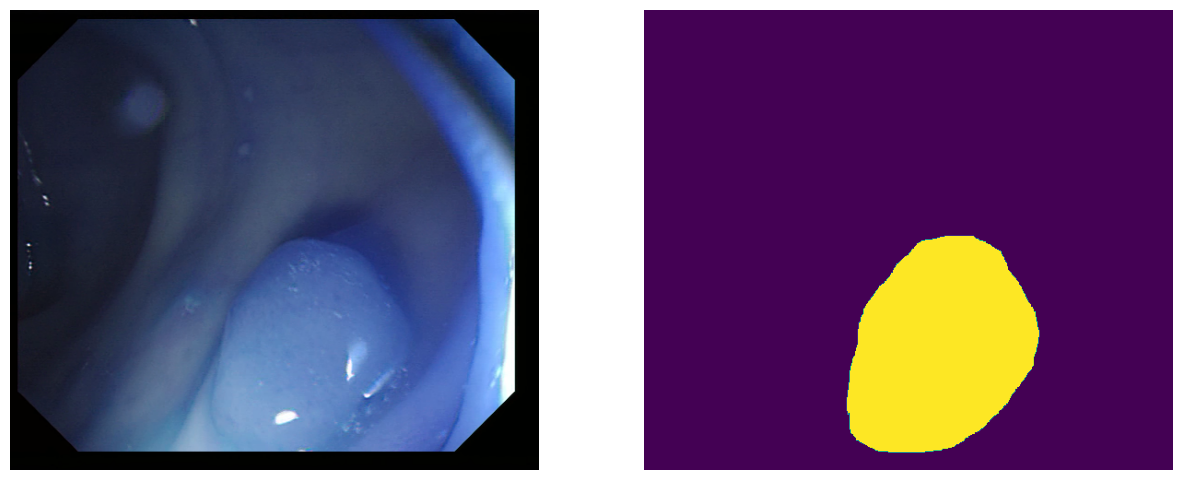

In [14]:
plt.figure(figsize = (15,15))

index = random.randint(0,len(images))
img = cv2.imread(df.iloc[index][0])
msk = cv2.imread(df.iloc[index][1])
msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
msk = np.expand_dims(msk, axis=-1)

plt.subplot(1,2,1)
plt.imshow(img)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(msk)
plt.axis(False)

In [15]:
img.shape

(500, 574, 3)

In [16]:
msk.shape

(500, 574, 1)

# Data Augmentation

#### Without creating a function, just to visualize how it is being done..🙃

In [17]:
import albumentations as A

IMG_SIZE = 256

train_augmented = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.2),
    A.VerticalFlip(p = 0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomRotate90(p=0.2)
])

val_augmented = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
])

In [18]:
sample_idx = random.randint(0,len(images))

sample_img = df.iloc[sample_idx][0]
sample_img = cv2.imread(sample_img)

sample_msk = df.iloc[sample_idx][1]
sample_msk = cv2.imread(sample_msk, cv2.IMREAD_GRAYSCALE)
sample_msk = np.expand_dims(sample_msk, axis=-1)

In [19]:
transformed = train_augmented(image = sample_img,
                              mask = sample_msk)

print(transformed['image'].shape)
print(transformed['mask'].shape)

(256, 256, 3)
(256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

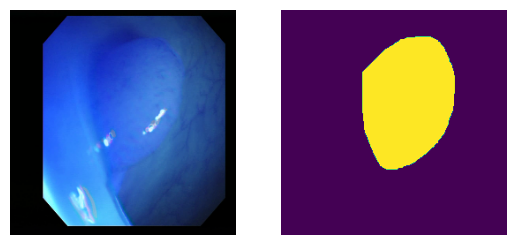

In [20]:
plt.subplot(1,2,1)
plt.imshow(transformed['image'])
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(transformed['mask'])
plt.axis(False)

# Data Augmentation

#### Creating functions for train and validation data augmentations

In [21]:
def train_augmentations():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.RandomCrop(width=256, height=256),
        A.HorizontalFlip(p=0.2),
        A.VerticalFlip(p = 0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.RandomRotate90(p=0.2)
    ])

def val_augmentations():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ])

# Create a custom dataset

In [22]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, transform = False):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row =  self.df.iloc[index]
        
        image_path = row[0]
        mask_path = row[1]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)
        
        if self.transform:
            data = self.transform(image = image, mask = mask)
            image = data['image']
            mask = data['mask']
            
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)
        
        image = torch.Tensor(image) / 255.
        mask = torch.round(torch.Tensor(mask) / 255.)
        
        return image, mask

# Split into Train-Val datasets

In [23]:
from sklearn.model_selection import train_test_split
train_dataset, valid_dataset = train_test_split(df, test_size=0.2, random_state=42)

In [24]:
train_dataset.shape, valid_dataset.shape

((304, 2), (76, 2))

In [25]:
train_dataset = SegmentationDataset(train_dataset, train_augmentations())
valid_dataset = SegmentationDataset(valid_dataset, val_augmentations())

In [26]:
len(train_dataset), len(valid_dataset)

(304, 76)

In [27]:
import random

index = random.randint(0,len(train_dataset))
image, mask = train_dataset[index]
image.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [28]:
image = image.permute(1,2,0)
mask = mask.permute(1,2,0)

In [29]:
mask.shape, image.shape

(torch.Size([256, 256, 1]), torch.Size([256, 256, 3]))

(-0.5, 255.5, 255.5, -0.5)

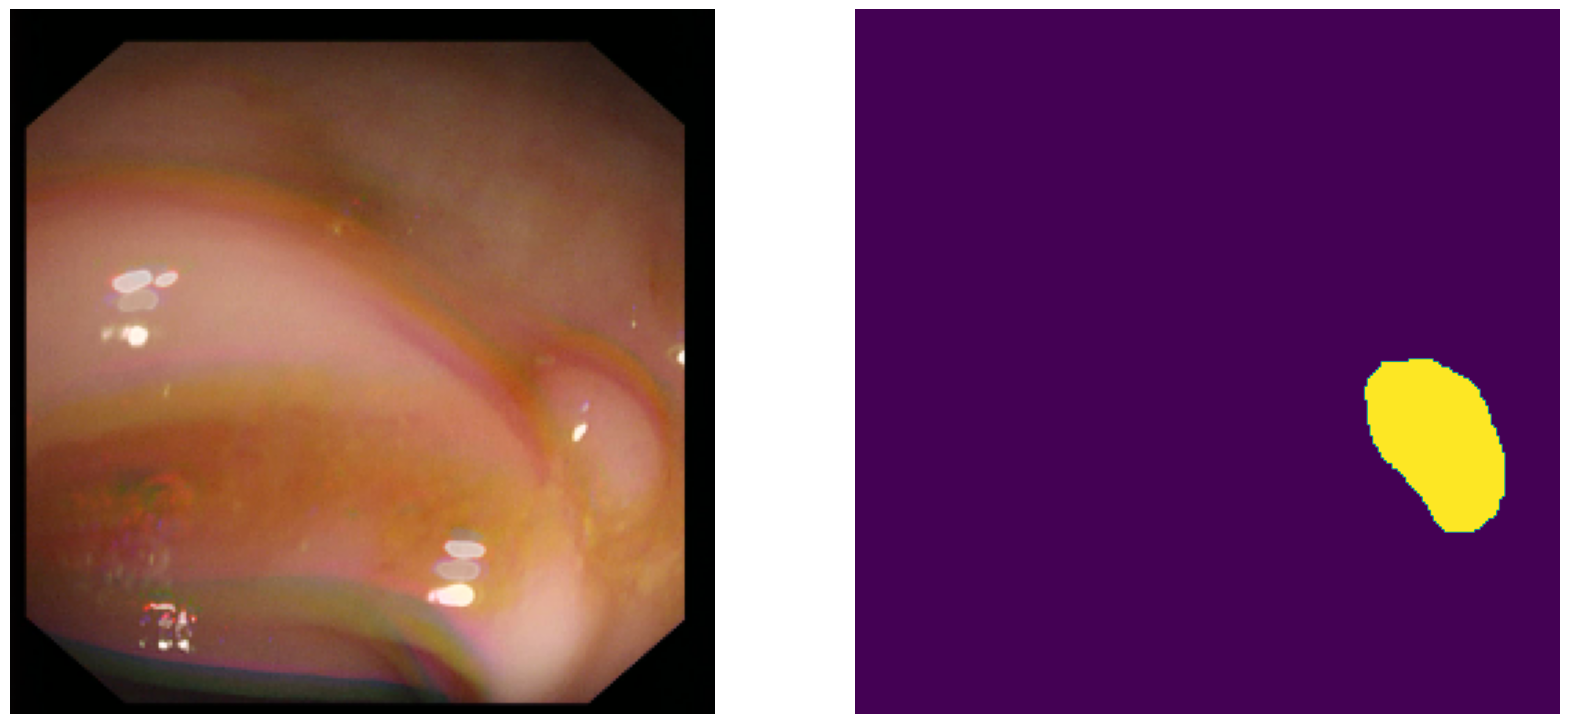

In [30]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(image)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis(False)

# Creating Training and Validation DataLoaders

In [31]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset = train_dataset,
                             batch_size = BATCH_SIZE,
                              shuffle = True)

valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                               shuffle = False)

In [32]:
len(train_dataloader), len(valid_dataloader)

(19, 5)

In [33]:
img, msk = next(iter(train_dataloader))

In [34]:
img.shape, msk.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

# Creating Segmentation Model

In [35]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch;

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-npqkhgnd
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-npqkhgnd
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 6db76a1106426ac5b55f39fba68168f3bccae7f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 904.1 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:0000:0100:01
  Created wheel for segmentation_models_pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106723 sha256=0488f995fece48696d6151df40541fdbb815e2afff16cf23c2a

In [36]:
# pip install -U git+https://github.com/facebookresearch/Detectron/tree/main/detectron/modeling;

In [37]:
import segmentation_models_pytorch as smp
from torch import nn

class SegmentationModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.architecture = smp.FPN(
            encoder_name = 'tu-efficientnet_b0',
            #encoder_name = 'efficientnet-b0',

            encoder_weights = 'imagenet',
            in_channels = 3,
            classes = 1,
            activation = None   
        )
        
    def forward(self, images, masks = None):
        logits = self.architecture(images)
        
        if (masks is not None):
            #print("Logits shape:", logits.shape)
            #print("Masks shape:", masks.shape)
            
            assert logits.shape == masks.shape, "Shapes of logits and masks must match"
            
            loss1 = smp.losses.DiceLoss(mode='binary')(logits,masks)
            loss2 = nn.BCEWithLogitsLoss()(logits,masks)
            
            return logits, loss1+loss2
        
        return logits

In [38]:
model = SegmentationModel()
model.to(device);

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

# Creating Train and Validation functions

In [39]:
def train_fn(dataloader,model,optimizer):
    
    model.train()
    total_loss = 0.0
    for images,masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        logits,loss = model(images,masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() #Tensor to number : [5] to 5
        
    return total_loss/len(dataloader) #Average loss
    

In [40]:
def valid_fn(dataloader, model):
    
    model.eval()
    total_loss = 0.0
    with torch.inference_mode():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            #print("Images shape after transfer:", images.shape)  # Added print statement
            #print("Masks shape after transfer:", masks.shape)  # Added print statement
            
            logits,loss = model(images,masks)
            total_loss += loss.item() 
            
    return total_loss/len(dataloader)


In [41]:
# hàm test thế
def calculate_dice(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient

def valid_fn(dataloader, model):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            logits, loss = model(images, masks)
            total_loss += loss.item()
            
            y_pred = (logits > 0.5).float()  # Chuyển đổi dự đoán thành nhị phân
            y_true = masks.float()
            dice = calculate_dice(y_true.cpu().numpy(), y_pred.cpu().numpy())
            total_dice += dice
            
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    
    return avg_loss, avg_dice

In [42]:
def train_fn(dataloader, model, optimizer):
    model.train()
    total_loss = 0.0
    total_dice = 0.0
    
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        logits, loss = model(images, masks)
        total_loss += loss.item()
        
        # Tính toán DICE
        y_pred = (logits > 0.5).float()  # Chuyển đổi dự đoán thành nhị phân
        y_true = masks.float()
        dice = calculate_dice(y_true.cpu().numpy(), y_pred.cpu().numpy())
        total_dice += dice
        
        loss.backward()
        optimizer.step()
    
    avg_loss = total_loss / len(dataloader)
    avg_dice = total_dice / len(dataloader)
    
    return avg_loss, avg_dice

In [43]:
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001)

# Training the model

In [44]:
epochs = 20
best_valid_loss = np.Inf
train_losses = []
valid_losses = []
train_dices = []
valid_dices = []

for epoch in range(epochs):
    train_loss, train_dice = train_fn(train_dataloader, model, optimizer)
    valid_loss, valid_dice = valid_fn(valid_dataloader, model)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_dices.append(train_dice)
    valid_dices.append(valid_dice)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print("The model is saved")
        
    print(f"Epoch: {epoch+1} | Training loss: {train_loss} | Validation loss: {valid_loss} | Training DICE: {train_dice} | Validation DICE: {valid_dice}")



100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


The model is saved
Epoch: 1 | Training loss: 1.0063210647357137 | Validation loss: 1.5225888729095458 | Training DICE: 0.43965580276978433 | Validation DICE: 0.16057331662713942


100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


The model is saved
Epoch: 2 | Training loss: 0.39349219124568136 | Validation loss: 0.4724827140569687 | Training DICE: 0.7553247059589043 | Validation DICE: 0.7265184915521127


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]


The model is saved
Epoch: 3 | Training loss: 0.2716987807499735 | Validation loss: 0.19979024529457093 | Training DICE: 0.8215056841735379 | Validation DICE: 0.8836455342702945


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch: 4 | Training loss: 0.21792172836629967 | Validation loss: 0.3280609786510468 | Training DICE: 0.8600355352542733 | Validation DICE: 0.8377204501233777


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


Epoch: 5 | Training loss: 0.19571026767555036 | Validation loss: 0.2452722281217575 | Training DICE: 0.8705044704120893 | Validation DICE: 0.8662792416770844


100%|██████████| 5/5 [00:01<00:00,  3.24it/s]


Epoch: 6 | Training loss: 0.15445333836894287 | Validation loss: 0.2224704384803772 | Training DICE: 0.9016516799831216 | Validation DICE: 0.870464217090438


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch: 7 | Training loss: 0.146553414432626 | Validation loss: 0.24343558102846147 | Training DICE: 0.9035341645323032 | Validation DICE: 0.8813088547869509


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch: 8 | Training loss: 0.1302498982925164 | Validation loss: 0.2286977529525757 | Training DICE: 0.9162391584409809 | Validation DICE: 0.8789083222356879


100%|██████████| 5/5 [00:01<00:00,  3.18it/s]


Epoch: 9 | Training loss: 0.12885326421574542 | Validation loss: 0.23701554536819458 | Training DICE: 0.9157348508507913 | Validation DICE: 0.8745429741357709


100%|██████████| 5/5 [00:01<00:00,  3.35it/s]


The model is saved
Epoch: 10 | Training loss: 0.12225354619716343 | Validation loss: 0.1486044332385063 | Training DICE: 0.9222282562255504 | Validation DICE: 0.9241939047425595


100%|██████████| 5/5 [00:01<00:00,  3.21it/s]


Epoch: 11 | Training loss: 0.10598336513105192 | Validation loss: 0.17869672328233718 | Training DICE: 0.9310446616121424 | Validation DICE: 0.8961802802938156


100%|██████████| 5/5 [00:01<00:00,  3.23it/s]


Epoch: 12 | Training loss: 0.10301725409532848 | Validation loss: 0.20074868202209473 | Training DICE: 0.9306882641960622 | Validation DICE: 0.8922001156501207


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch: 13 | Training loss: 0.09509698693689547 | Validation loss: 0.19635601043701173 | Training DICE: 0.9386118657063308 | Validation DICE: 0.8982819952962047


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Epoch: 14 | Training loss: 0.08418626769592888 | Validation loss: 0.22000372409820557 | Training DICE: 0.9449398038463676 | Validation DICE: 0.8912710832527768


100%|██████████| 5/5 [00:01<00:00,  3.06it/s]


Epoch: 15 | Training loss: 0.08826714322755211 | Validation loss: 0.2568763643503189 | Training DICE: 0.9425000652795363 | Validation DICE: 0.8731839438430476


100%|██████████| 5/5 [00:01<00:00,  3.27it/s]


Epoch: 16 | Training loss: 0.09426870589193545 | Validation loss: 0.1751647487282753 | Training DICE: 0.9386997625333606 | Validation DICE: 0.9028480578201773


100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


Epoch: 17 | Training loss: 0.09346965112184223 | Validation loss: 0.1881308913230896 | Training DICE: 0.9388023002829371 | Validation DICE: 0.9019557315830926


100%|██████████| 5/5 [00:01<00:00,  3.32it/s]


Epoch: 18 | Training loss: 0.09653415687774357 | Validation loss: 0.2911750555038452 | Training DICE: 0.9393137505397613 | Validation DICE: 0.8616193614112682


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Epoch: 19 | Training loss: 0.10702198077189295 | Validation loss: 0.21122862696647643 | Training DICE: 0.9303932909742308 | Validation DICE: 0.8898020100451198


100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

Epoch: 20 | Training loss: 0.09032522338001352 | Validation loss: 0.18207592219114305 | Training DICE: 0.9416580953192506 | Validation DICE: 0.9027224609076244


In [45]:
avg_valid_loss = np.mean(valid_losses)
avg_valid_dice = np.mean(valid_dices)

print(f"Average Validation loss: {avg_valid_loss}")
print(f"Average Validation DICE: {avg_valid_dice}")

Average Validation loss: 0.2974437769502401
Average Validation DICE: 0.8407110173672331


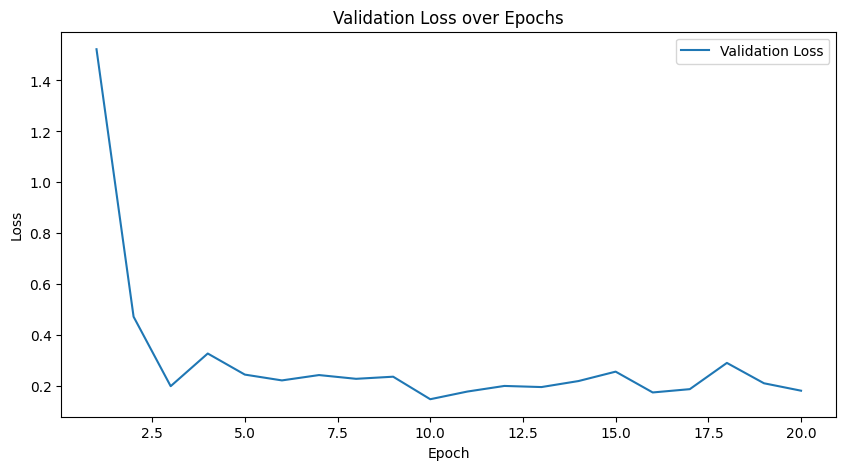

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

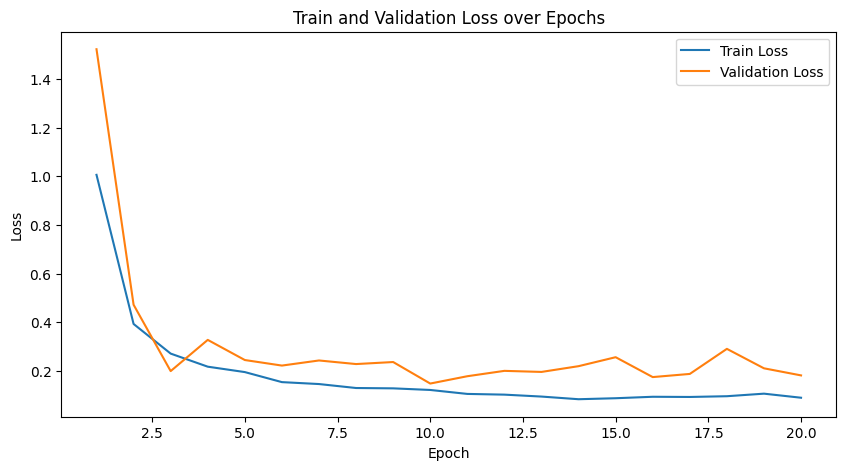

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Validation Loss')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

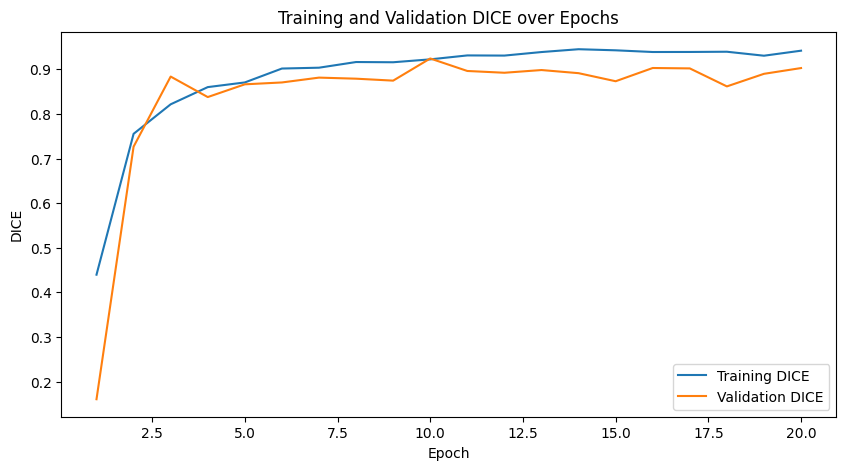

In [48]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_dices, label='Training DICE')
plt.plot(range(1, epochs + 1), valid_dices, label='Validation DICE')
plt.title('Training and Validation DICE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('DICE')
plt.legend()
plt.grid(False)
plt.show()

In [49]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pt'))

<All keys matched successfully>

# Predicting for a sample image

(-0.5, 255.5, 255.5, -0.5)

<Figure size 1000x1000 with 0 Axes>

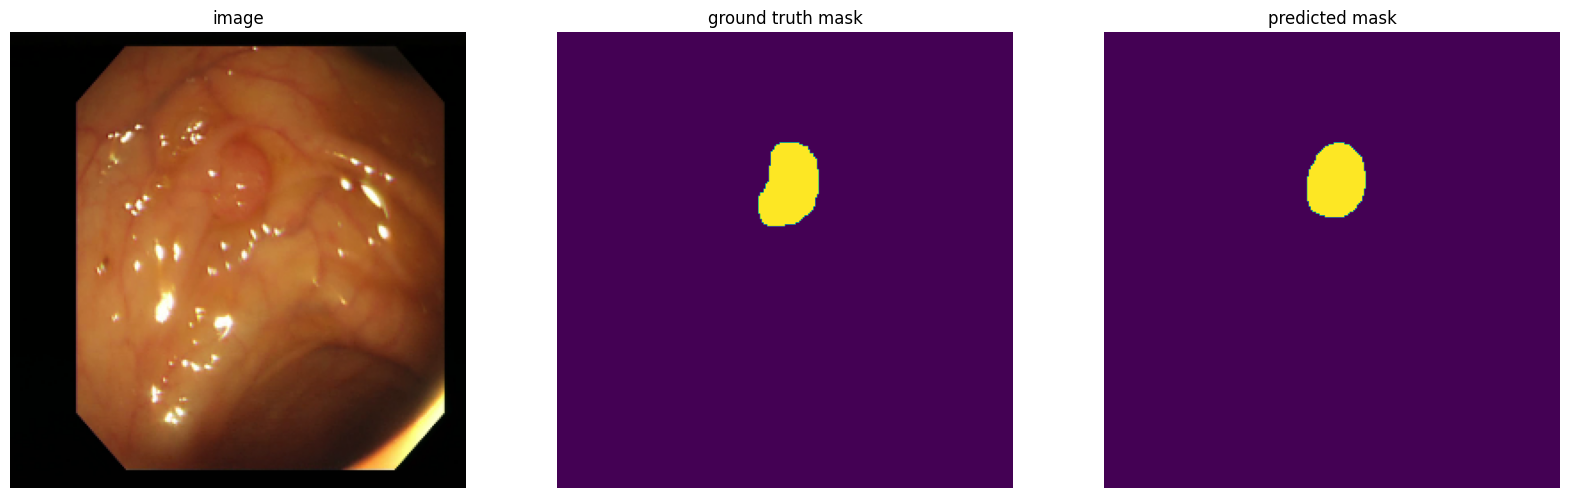

In [50]:
index = random.randrange(0, len(valid_dataset))
image,mask = valid_dataset[index]
image = image.to(device)
logits_mask = model(image.unsqueeze(0)); # C,H,W -> 1,C,H,W
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

image = image.detach().cpu()
pred_mask = pred_mask.detach().cpu().squeeze(0)

plt.figure(figsize=(10,10))

image = image.permute(1,2,0)
mask = mask.permute(1,2,0)
pred_mask = pred_mask.permute(1,2,0)

plt.figure(figsize = (20,20))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title('image')
plt.axis(False)

plt.subplot(1,3,2)
plt.imshow(mask)
plt.title('ground truth mask')
plt.axis(False)

plt.subplot(1,3,3)
plt.imshow(pred_mask)
plt.title('predicted mask')
plt.axis(False)

In [51]:
pip install thop

Note: you may need to restart the kernel to use updated packages.


In [52]:
import torch
from thop import profile
import torch.nn.functional as F
# Load mô hình FPN đã có
model = SegmentationModel()  
# Kích thước mong muốn của ảnh đầu vào
input_height = 500
input_width = 574
input_channels = 3
# Ảnh đầu vào
input = torch.randn(1, input_channels, input_height, input_width)
# Kích thước mong muốn sau khi padding
padded_height = 512
padded_width = 576
# Tính toán lượng padding cần thêm vào ảnh
pad_height = padded_height - input_height
pad_width = padded_width - input_width
# Thêm viền cho ảnh đầu vào
padded_input = F.pad(input, (0, pad_width, 0, pad_height))
# Tính toán FLOPs
flops, params = profile(model, inputs=(padded_input,))
print(f"FLOPs: {flops}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.UpsamplingBilinear2d'>.
FLOPs: 11110026752.0


In [53]:

model = SegmentationModel()
model.eval()
total_params = sum(p.numel() for p in model.parameters())
print("Số lượng tham số trong mô hình:", total_params)

Số lượng tham số trong mô hình: 5347325


In [54]:
from tabulate import tabulate
model = SegmentationModel()

model.eval()

total_params = sum(p.numel() for p in model.parameters())
print("Số lượng tham số trong mô hình:", total_params)

table = []
for name, module in model.named_children():
    row = [f"Layer ({name})", "Type", "Output Shape", "Param #"]
    table.append(row)
    for layer_name, param in module.named_parameters():
        output_shape = " ".join(str(x) for x in list(param.data.size())) if param.data is not None else "N/A"
        row = ["", "", layer_name, output_shape, param.numel()]
        table.append(row)

print(tabulate(table, headers="firstrow", tablefmt="grid"))

Số lượng tham số trong mô hình: 5347325
+----+------------------------+------------------------------------------------+----------------+-----------+
|    | Layer (architecture)   | Type                                           | Output Shape   |   Param # |
+====+========================+================================================+================+===========+
|    |                        | encoder.model.conv_stem.weight                 | 32 3 3 3       |       864 |
+----+------------------------+------------------------------------------------+----------------+-----------+
|    |                        | encoder.model.bn1.weight                       | 32             |        32 |
+----+------------------------+------------------------------------------------+----------------+-----------+
|    |                        | encoder.model.bn1.bias                         | 32             |        32 |
+----+------------------------+------------------------------------------------+

In [55]:
import torch.nn as nn

# Giả sử 'model' là mô hình của bạn
model = SegmentationModel()

# Lặp qua từng lớp trong mô hình và in ra tên của từng lớp
for name, layer in model.named_modules():
    print(name)


architecture
architecture.encoder
architecture.encoder.model
architecture.encoder.model.conv_stem
architecture.encoder.model.bn1
architecture.encoder.model.bn1.drop
architecture.encoder.model.bn1.act
architecture.encoder.model.blocks
architecture.encoder.model.blocks.0
architecture.encoder.model.blocks.0.0
architecture.encoder.model.blocks.0.0.conv_dw
architecture.encoder.model.blocks.0.0.bn1
architecture.encoder.model.blocks.0.0.bn1.drop
architecture.encoder.model.blocks.0.0.bn1.act
architecture.encoder.model.blocks.0.0.se
architecture.encoder.model.blocks.0.0.se.conv_reduce
architecture.encoder.model.blocks.0.0.se.act1
architecture.encoder.model.blocks.0.0.se.conv_expand
architecture.encoder.model.blocks.0.0.se.gate
architecture.encoder.model.blocks.0.0.conv_pw
architecture.encoder.model.blocks.0.0.bn2
architecture.encoder.model.blocks.0.0.bn2.drop
architecture.encoder.model.blocks.0.0.bn2.act
architecture.encoder.model.blocks.0.0.drop_path
architecture.encoder.model.blocks.1
archit